In [1]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/twitter-airline-sentiment/Tweets.csv
/kaggle/input/twitter-airline-sentiment/database.sqlite


**Importing all the required Libraries**

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

**reading the csv file**

In [3]:
df=pd.read_csv('/kaggle/input/twitter-airline-sentiment/Tweets.csv')

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


**to get the information**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

**To get the sum of null values**

In [6]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

**get the column names**

In [7]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [8]:
text_df =df.drop(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'], axis=1)

**to get the top 5 text**

In [9]:
text_df.head()

,text
0,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials t...
2,@VirginAmerica I didn't today... Must mean I n...
3,@VirginAmerica it's really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...


**prints the text**

In [10]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

@VirginAmerica What @dhepburn said. 

@VirginAmerica plus you've added commercials to the experience... tacky. 

@VirginAmerica I didn't today... Must mean I need to take another trip! 

@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse 

@VirginAmerica and it's a really big bad thing about it 



**get the info**

In [11]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14640 non-null  object
dtypes: object(1)
memory usage: 114.5+ KB


**Data processing starts here**

In [13]:
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\s+|www\s+https\s+",'',text,flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)


In [14]:
text_df.text =text_df['text'].apply(data_processing)

**Dropping the duplicates**

In [16]:
text_df=text_df.drop_duplicates('text')

**Stemming**

In [17]:
stemmer=PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [18]:
text_df['text']= text_df['text'].apply(lambda x: stemming(x))

**get the top 5 text**

In [19]:
text_df.head()

,text
0,virginamerica dhepburn said
1,virginamerica plus youve added commercials exp...
2,virginamerica didnt today must mean need take ...
3,virginamerica really aggressive blast obnoxiou...
4,virginamerica really big bad thing


**Print the texts**

In [20]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

virginamerica dhepburn said 

virginamerica plus youve added commercials experience tacky 

virginamerica didnt today must mean need take another trip 

virginamerica really aggressive blast obnoxious entertainment guests faces amp little recourse 

virginamerica really big bad thing 



**Get the information**

In [21]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14300 entries, 0 to 14639
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14300 non-null  object
dtypes: object(1)
memory usage: 223.4+ KB


In [22]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [23]:
text_df['polarity'] = text_df['text'].apply(polarity)

**top 10 heads with polarity**

In [24]:
text_df.head(10)

,text,polarity
0,virginamerica dhepburn said,0.000000
1,virginamerica plus youve added commercials exp...,0.000000
2,virginamerica didnt today must mean need take ...,-0.312500
3,virginamerica really aggressive blast obnoxiou...,0.006250
4,virginamerica really big bad thing,-0.350000
5,virginamerica seriously would pay 30 flight se...,-0.516667
6,virginamerica yes nearly every time fly vx ear...,0.450000
7,virginamerica really missed prime opportunity ...,0.200000
8,virginamerica well didntbut,0.000000
9,virginamerica amazing arrived hour early youre...,0.466667


**Labeling the sentiment**

In [25]:
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral" 
    elif label>0:
        return "Positive"
    

In [26]:
text_df['sentiment']= text_df['polarity'].apply(sentiment)

**to get the top 5 text**

In [27]:
text_df.head()

,text,polarity,sentiment
0,virginamerica dhepburn said,0.00000,Neutral
1,virginamerica plus youve added commercials exp...,0.00000,Neutral
2,virginamerica didnt today must mean need take ...,-0.31250,Negative
3,virginamerica really aggressive blast obnoxiou...,0.00625,Positive
4,virginamerica really big bad thing,-0.35000,Negative


**plotting a Histogram chart**

<Axes: xlabel='sentiment', ylabel='count'>

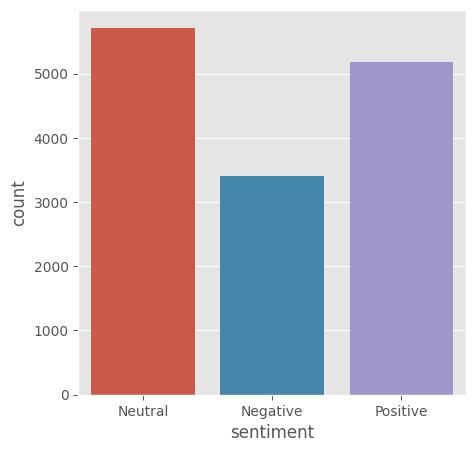

In [28]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment',data=text_df)

**Plotting a pie chart**

Text(0.5, 1.0, 'Distribution of sentiments')

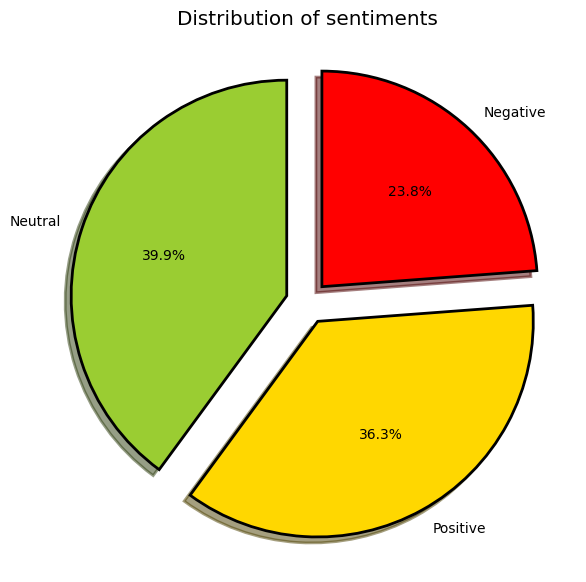

In [29]:
fig=plt.figure(figsize=(7,7))
colors=("yellowgreen","gold","red")
wp={'linewidth':2,'edgecolor':"black"}
tags= text_df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%',shadow=True,colors = colors,
         startangle =90,wedgeprops = wp, explode = explode , label = '')
plt.title('Distribution of sentiments')

**sentiment == 'Positive'**

In [30]:
pos_tweets = text_df[text_df.sentiment == 'Positive']
pos_tweet = pos_tweets.sort_values(['polarity'],ascending=False)
pos_tweets.head()

,text,polarity,sentiment
3,virginamerica really aggressive blast obnoxiou...,0.006250,Positive
6,virginamerica yes nearly every time fly vx ear...,0.450000,Positive
7,virginamerica really missed prime opportunity ...,0.200000,Positive
9,virginamerica amazing arrived hour early youre...,0.466667,Positive
11,virginamerica lt3 pretty graphics much better ...,0.216667,Positive


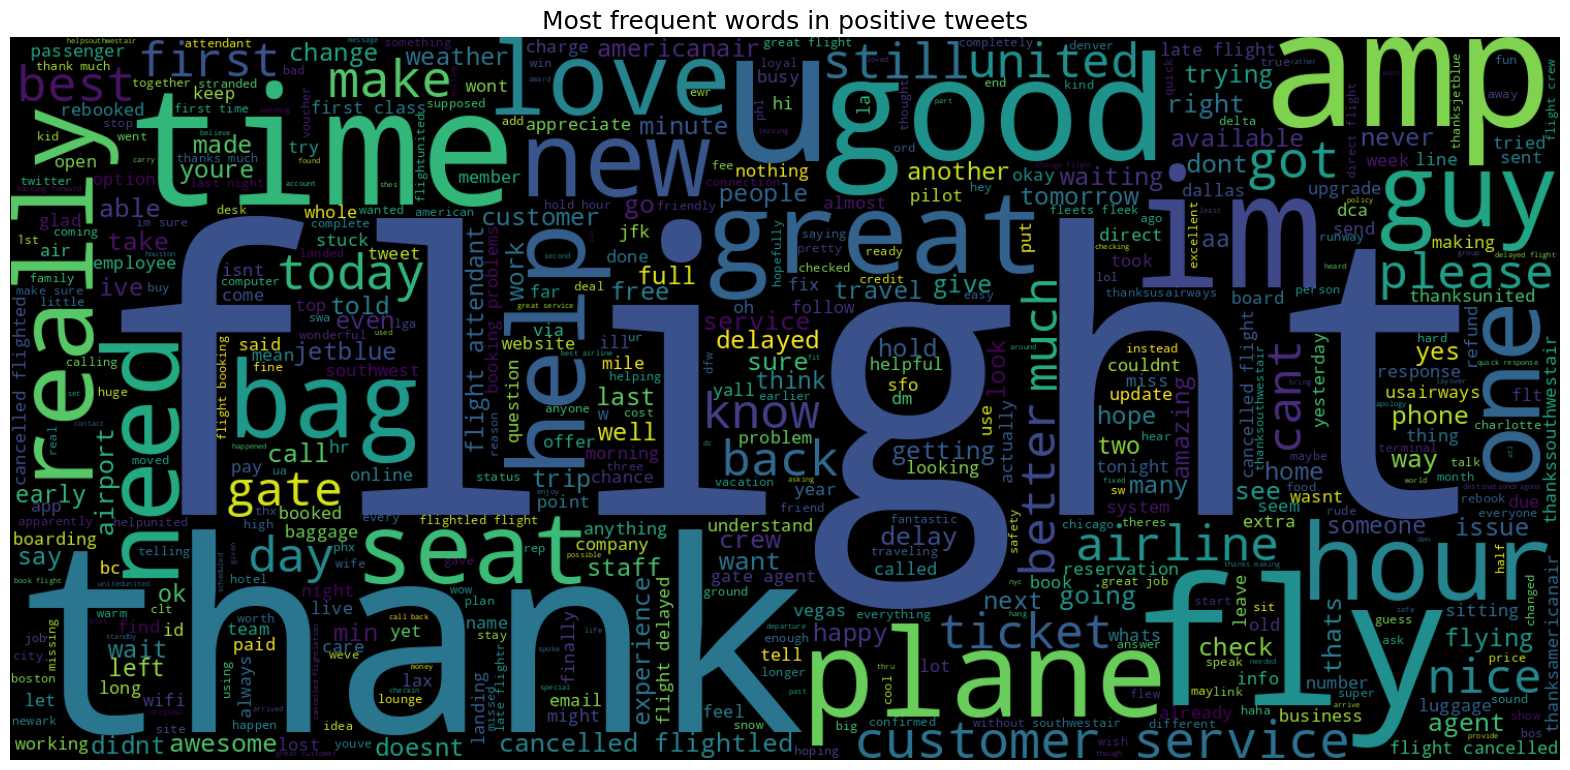

In [34]:
text = ''.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15),facecolor='None')
wordcloud=WordCloud(max_words=500,width = 1500,height = 700).generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets',fontsize=18)
plt.show()

**sentiment == 'Positive'**

In [32]:
neg_tweets = text_df[text_df.sentiment == 'Positive']
neg_tweet = neg_tweets.sort_values(['polarity'],ascending=False)
neg_tweets.head()

,text,polarity,sentiment
2,virginamerica didnt today must mean need take ...,-0.312500,Negative
4,virginamerica really big bad thing,-0.350000,Negative
5,virginamerica seriously would pay 30 flight se...,-0.516667,Negative
26,virginamerica happened 2 ur vegan food options...,-0.075000,Negative
32,virginamerica help left expensive headphones f...,-0.250000,Negative


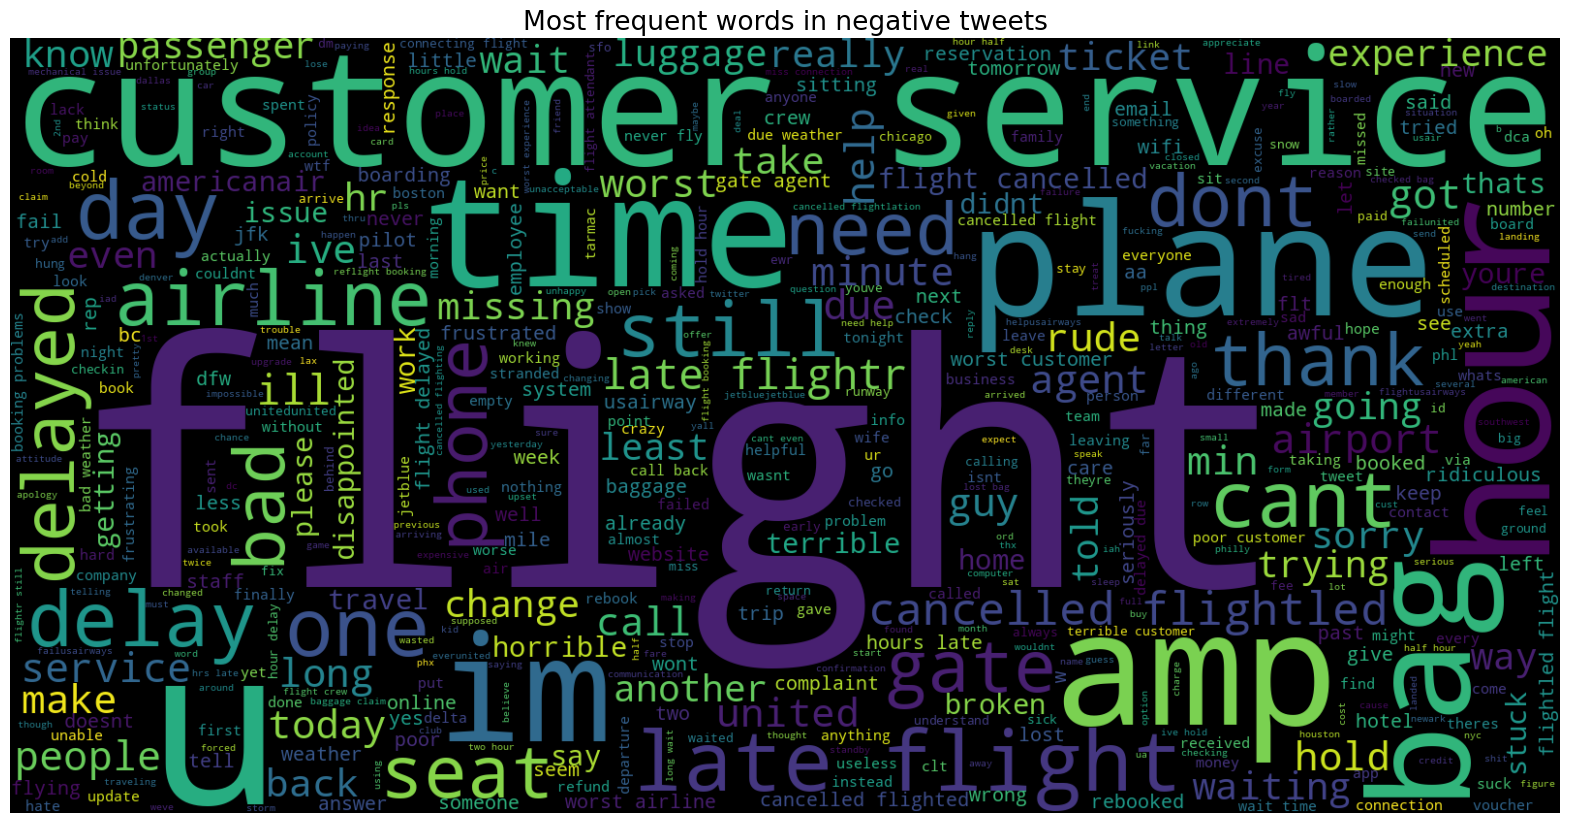

In [33]:
text = ''.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15),facecolor='None')
wordcloud=WordCloud(max_words=500,width = 1600,height = 800).generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets',fontsize=19)
plt.show()

**sentiment == 'Neutral'**

In [35]:
neutral_tweets = text_df[text_df.sentiment == 'Neutral']
neutral_tweet = neutral_tweets.sort_values(['polarity'],ascending=False)
neutral_tweets.head()

,text,polarity,sentiment
0,virginamerica dhepburn said,0.0,Neutral
1,virginamerica plus youve added commercials exp...,0.0,Neutral
8,virginamerica well didntbut,0.0,Neutral
10,virginamerica know suicide second leading caus...,0.0,Neutral
15,virginamerica sfopdx schedule still mia,0.0,Neutral


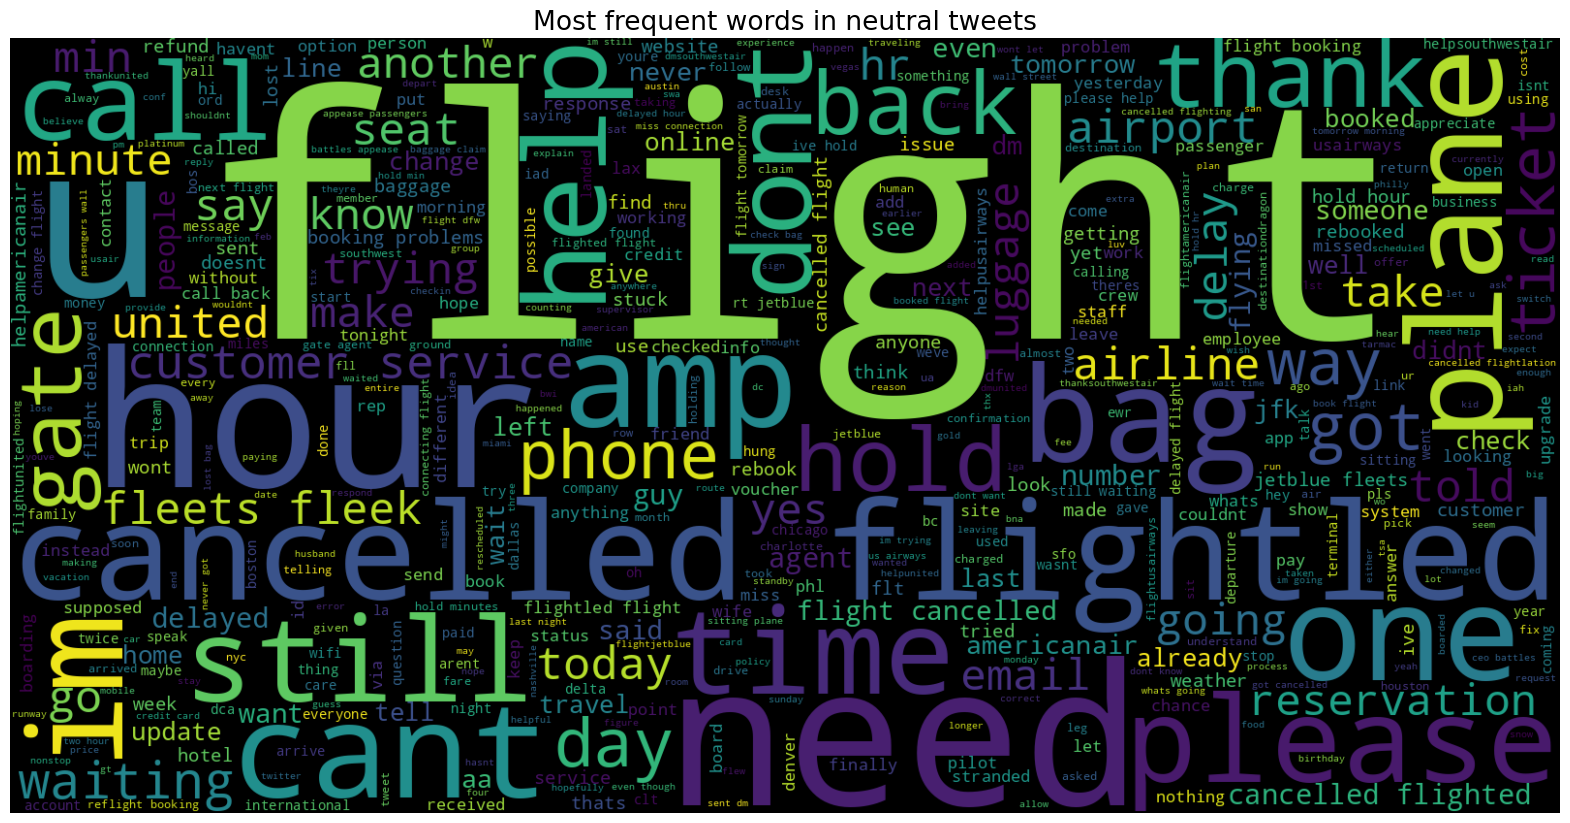

In [36]:
text = ''.join([word for word in neutral_tweets['text']])
plt.figure(figsize=(20,15),facecolor='None')
wordcloud=WordCloud(max_words=500,width = 1600,height = 800).generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets',fontsize=19)
plt.show()

In [37]:
vect = CountVectorizer(ngram_range=(1,2)).fit(text_df['text'])

In [38]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features:\n {}".format(feature_names[:20]))

Number of features: 109636

First 20 features:
 ['0011' '0011 80055558000' '0016' '0016 964012' '0016 964077'
 '0016 964078' '006' '006 news' '0162389030167' '0162389030167 refund'
 '0162424965446' '0162424965446 please' '0162431184663'
 '0162431184663 agents' '0167560070877' '0167560070877 fsqthg' '0214'
 '0214 started' '021mbps' '021mbps amp']


**Dividing into x and y**

In [39]:
x= text_df['text']
y= text_df['sentiment']
x=vect.transform(x)

**Splitting into Train and Test model**

In [40]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

**Printing the shape of x and y train and test model**

In [41]:
print("Size of x_train: ",(x_train.shape))
print("Size of y_train: ",(y_train.shape))
print("Size of x_test: ",(x_test.shape))
print("Size of y_test: ",(y_test.shape))

Size of x_train:  (11440, 109636)
Size of y_train:  (11440,)
Size of x_test:  (2860, 109636)
Size of y_test:  (2860,)


**importing warning**

In [42]:
import warnings
warnings.filterwarnings('ignore')

**LogisticRegression()**

In [43]:
logreg = LogisticRegression()
logreg.fit(x_train,y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc =accuracy_score(logreg_pred,y_test)
print("Test accuracy : {:.2f}%".format(logreg_acc*100))

Test accuracy : 86.08%


**Printing the confusion matrix and classification report**

In [44]:
print(confusion_matrix(y_test,logreg_pred))
print("\n")
print(classification_report(y_test,logreg_pred))

[[ 513  137   56]
 [   6 1082   19]
 [  39  141  867]]


              precision    recall  f1-score   support

    Negative       0.92      0.73      0.81       706
     Neutral       0.80      0.98      0.88      1107
    Positive       0.92      0.83      0.87      1047

    accuracy                           0.86      2860
   macro avg       0.88      0.84      0.85      2860
weighted avg       0.87      0.86      0.86      2860



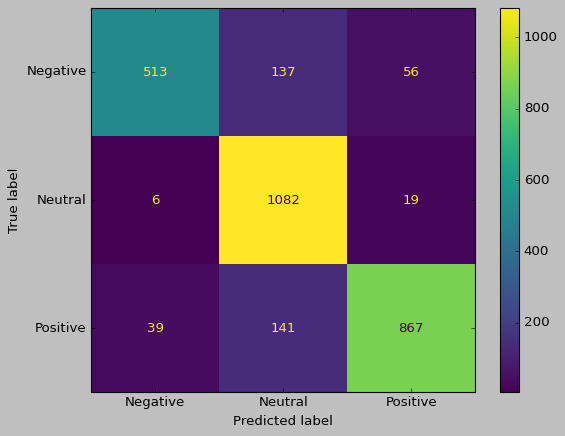

In [45]:
style.use('classic')
cm = confusion_matrix(y_test,logreg_pred,labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm ,display_labels=logreg.classes_)
disp.plot()

**importing library**

In [46]:
from sklearn.model_selection import GridSearchCV

In [47]:
param_grid={'C':[0.001,0.01,0.1,1,10]}
grid = GridSearchCV(LogisticRegression(),param_grid)
grid.fit(x_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [49]:
print("Best parameters:",grid.best_params_)

Best parameters: {'C': 10}


In [50]:
y_pred = grid.predict(x_test)

In [51]:
logreg_acc= accuracy_score(y_pred,y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 87.38%


**Printing the confusion matrix and classification report**

In [52]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

[[ 535  119   52]
 [   7 1083   17]
 [  39  127  881]]


              precision    recall  f1-score   support

    Negative       0.92      0.76      0.83       706
     Neutral       0.81      0.98      0.89      1107
    Positive       0.93      0.84      0.88      1047

    accuracy                           0.87      2860
   macro avg       0.89      0.86      0.87      2860
weighted avg       0.88      0.87      0.87      2860



In [53]:
from sklearn.svm import LinearSVC

**LinearSVC()**

In [54]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train,y_train)

LinearSVC()

In [55]:
svc_pred = SVCmodel.predict(x_test)
svc_acc = accuracy_score(svc_pred,y_test)
print("Test accuracy: {:.2f}%".format(svc_acc*100))

Test accuracy: 88.74%


**Printing the confusion matrix and classification report**

In [56]:
print(confusion_matrix(y_test,svc_pred))
print("\n")
print(classification_report(y_test,svc_pred))

[[ 554  103   49]
 [   8 1081   18]
 [  36  108  903]]


              precision    recall  f1-score   support

    Negative       0.93      0.78      0.85       706
     Neutral       0.84      0.98      0.90      1107
    Positive       0.93      0.86      0.90      1047

    accuracy                           0.89      2860
   macro avg       0.90      0.87      0.88      2860
weighted avg       0.89      0.89      0.89      2860



In [57]:
grid = {
    'C':[0.01,0.1,1,10],
    'kernel':["linear","poly","rbf","sigmoid"],
    'degree':[1,3,5,7],
    'gamma':[0.01,1]
}
grid = GridSearchCV(SVCmodel,param_grid)
grid.fit(x_train,y_train)

GridSearchCV(estimator=LinearSVC(), param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [58]:
print("Best Parameter:",grid.best_params_)

Best Parameter: {'C': 1}


In [59]:
y_pred = grid.predict(x_test)

In [60]:
logreg_acc = accuracy_score(y_pred,y_test)
print("Test accuracy : {:.2f}%".format(logreg_acc*100))

Test accuracy : 88.74%


**Printing the confusion matrix and classification report**

In [61]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

[[ 554  103   49]
 [   8 1081   18]
 [  36  108  903]]


              precision    recall  f1-score   support

    Negative       0.93      0.78      0.85       706
     Neutral       0.84      0.98      0.90      1107
    Positive       0.93      0.86      0.90      1047

    accuracy                           0.89      2860
   macro avg       0.90      0.87      0.88      2860
weighted avg       0.89      0.89      0.89      2860



* Logistic Regression       -- 86.08%
* Tuned Logistic Regression -- 87.38%
* SVC                       -- 88.74%
* Tuned SVC                 -- 88.74%

*********************************************************************************************************************************************************
